This is getting worse by the day.

Last time I used for-loop I was able to do 10 years, 500 fields at a time.
Now, 1 year 20 fields gives trouble.
(Dec 21, 2023)


In [ ]:
try:
    import shutup
except ImportError:
  !pip install shutup
  import shutup

shutup.please() # kill some of the messages

import pickle, time, datetime, scipy
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date


#### Print Local Time for no reason!

colab runs on cloud. So, the time is not our local time.
This page is useful to determine how to do this.

In [ ]:
!rm /etc/localtime
# !ln -s /usr/share/zoneinfo/US/Central /etc/localtime
!ln -s /usr/share/zoneinfo/US/Pacific /etc/localtime
!date

Fri Dec  8 02:31:16 PM PST 2023


### geopandas and geemap must be installed every time.

In [ ]:
# !pip install geopandas geemap
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print('geemap not installed. Must be installed every tim to run this notebook. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

    print('geopandas not installed. Must be installed every time to run this notebook. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])
    subprocess.check_call(["python", '-m', 'pip', 'install', 'google.colab'])

# **Authenticate and import libraries**

We have to impor tthe libraries we need. Moreover, we need to Authenticate every single time!

In [ ]:
import json, geemap, ee, folium
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

### **Mount Google Drive and import my Python modules**

Here we are importing the Python functions that are written by me and are needed; ```NASA core``` and ```NASA plot core```.

Note to self: These are on Google Drive now. Perhaps we can import them from GitHub.



In [ ]:
# Mount YOUR google drive in Colab
from google.colab import drive
drive.mount('/content/drive')
import sys
# sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/")
sys.path.insert(0,"/content/drive/My Drive/WSU_job/joel_pipeline/")
import NASA_core as nc
import NASA_plot_core as ncp
import GEE_Python_core as gpc

# **Change Current directory to the Colab folder on Google Drive**
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/") # Colab Notebooks
# !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_base = "/content/drive/MyDrive/WSU_job/joel_pipeline/"
shp_dir = data_base + "shapefiles/"
model_dir = data_base + "Models/"

### Please tell me where to look for the shapefile!

<font size="5"><font color='red'>**Note:**</font></font> An ```ID``` column **must** be present in your shapefile. The code uses the ```ID``` to perform operations on each field. i.e. Each field (each row in data section of your shapefile) must be associated with a unique ID in a column called ```ID```.

<font size="5"><font color='red'>**Note:**</font></font>
Columns in the cell below must exist in your shapefile, otherwise, change
them to the columns you have.

<font size="5"><font color='red'>**Suggestion:**</font></font> Change column names in your shapefile, otherwise, you have to make more changes in the rest of the code.

This is how columns can be renamed

```df.rename(columns={'old_col_1': 'new_col_1', 'old_col_2': 'new_col_2'}, inplace=True)```

e.g.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html

In [ ]:
# we read our shapefile in to a geopandas data frame using the geopandas.read_file method
# we'll make sure it's initiated in the EPSG 4326 CRS
SF_subdir, SF_file_name = "Grant_4Fields/", "Grant_4Fields"
SF_subdir, SF_file_name = "GrantTest2022/", "GrantTest2022"

SF = gpd.read_file(shp_dir + SF_subdir + SF_file_name + ".shp", crs='EPSG:4326')
SF.head(2)

,CropType,Irrigation,InitialSur,LastSurvey,DataSource,Notes,TRS,RotationCr,CoverCrop,ExactAcres,...,ID,CropTyp,NAcres,Acres,Irrigtn,LstSrvD,DataSrc,countynew,county,geometry
0,Timothy,Center Pivot,2003-07-01,2020-08-04,WSDA,None,T17R25E27,"Bean, Dry",<Null>,149.343775,...,None,Timothy,149.0,149.0,Center Pivot,8/4/2020,WSDA,Grant,Grant,"POLYGON ((563278.110 178768.092, 563274.296 17..."
1,"Bean, Dry",Rill,2003-07-01,2020-08-04,WSDA,None,T17R25E28,"Corn, Field",<Null>,19.511489,...,None,"Bean, Dry",20.0,20.0,Rill,8/4/2020,WSDA,Grant,Grant,"POLYGON ((561793.025 178434.291, 561806.328 17..."


<font size="4.5"><font color='red'>**Note:**</font></font>

IF column ```ID``` is not there or is not populated do it here:

In [ ]:
# I can only predict so many situations.

if not("ID" in SF.columns):
  SF["ID"] = ["field_" + str(x+1) + "_" + SF_file_name for x in SF.index]

if  type(SF.ID[1]) != str:
  SF["ID"] = ["field_" + str(x+1) + "_" + SF_file_name for x in SF.index]

SF.head(2)

,CropType,Irrigation,InitialSur,LastSurvey,DataSource,Notes,TRS,RotationCr,CoverCrop,ExactAcres,...,ID,CropTyp,NAcres,Acres,Irrigtn,LstSrvD,DataSrc,countynew,county,geometry
0,Timothy,Center Pivot,2003-07-01,2020-08-04,WSDA,None,T17R25E27,"Bean, Dry",<Null>,149.343775,...,field_1_GrantTest2022,Timothy,149.0,149.0,Center Pivot,8/4/2020,WSDA,Grant,Grant,"POLYGON ((563278.110 178768.092, 563274.296 17..."
1,"Bean, Dry",Rill,2003-07-01,2020-08-04,WSDA,None,T17R25E28,"Corn, Field",<Null>,19.511489,...,field_2_GrantTest2022,"Bean, Dry",20.0,20.0,Rill,8/4/2020,WSDA,Grant,Grant,"POLYGON ((561793.025 178434.291, 561806.328 17..."


<font size="4.5"><font color='red'>**Note:**</font></font>
If you want to susbset fields, this is the time. After this point the type of ```SF``` changes and doing some stuff becomes hard/impossible. You can make a back up of ```SF``` if you want. Like so ```SF_backup = SF.copy()```.

In [ ]:
### subset of SF can be done like this:
# SF = SF[0:2] # replace 2 with the number you desire

In [ ]:
### for possible future use grab the data part of the shapefile
keep_cols = ["ID", "Acres", "county", "CropTyp", \
             "DataSrc", "Irrigtn", "LstSrvD"]

SF_data = SF[keep_cols].copy()
print (f"{SF_data.shape = }")

"""
   Drop extra useless columns. Saves space.**
   Also, GEE behaves strangely. It has problem with Notes column.
"""

# The only thing we need at this stage is only ID and geometry.
badCols = [x for x in list(SF.columns) if not (x in ["ID", "geometry"])]
SF = SF.drop(columns=badCols)
IDs = list(SF_data.ID.unique())

long_eq = "=============================================================================="
print (f"{type(SF) = }")
print (long_eq)
print (f"{SF.shape = }", )
print (long_eq)
SF.head(2)

SF_data.shape = (26, 7)
list(SF_data.columns)= ['ID', 'Acres', 'county', 'CropTyp', 'DataSrc', 'Irrigtn', 'LstSrvD']
type(SF) = <class 'geopandas.geodataframe.GeoDataFrame'>
SF.shape = (26, 2)


,ID,geometry
0,field_1_GrantTest2022,"POLYGON ((563278.110 178768.092, 563274.296 17..."
1,field_2_GrantTest2022,"POLYGON ((561793.025 178434.291, 561806.328 17..."


# **Form Geographical Regions**

  - First, define a big region that covers Eastern Washington.
  - Convert shapefile to ```ee.featurecollection.FeatureCollection```.


### Fetch data from GEE.
<font size="4.5"><font color='red'>**NOTE:**</font></font>
Try to make the following red box as small as possible. This can affect the resources CoLab let us use!

In [ ]:
xmin, xmax = -125.0, -116.0;
ymin, ymax = 45.0, 49.0;

xmed = (xmin + xmax) / 2.0;
ymed = (ymin+ymax) / 2.0;

WA1 = ee.Geometry.Polygon([[xmin, ymin], [xmin, ymax], [xmed, ymax], [xmed, ymin], [xmin, ymin]]);
WA2 = ee.Geometry.Polygon([[xmed, ymin], [xmed, ymax], [xmax, ymax], [xmax, ymin], [xmed, ymin]]);
WA = [WA1,WA2];
WA = [WA2];
big_rectangle = ee.FeatureCollection(WA);
if type(SF) != ee.featurecollection.FeatureCollection:
  SF = geemap.geopandas_to_ee(SF)

<font size="5"><font color='red'>**WARNING:**</font></font>

For some reason the function ```feature2ee(.)``` does not work ***when*** it is imported from ```core``` module. (However, it works when it is directly written here!!!) So, What the happens with the rest of functions, e.g. smoothing functions, we want to use here?

# Visualize the big region encompassing the Eastern Washington

In [ ]:
Map = geemap.Map(center=[ymed, xmed], zoom=7)
Map.addLayer(WA1, {'color': 'red'}, 'Western Half')
Map.addLayer(WA2, {'color': 'red'}, 'Eastern Half')
Map.addLayer(SF, {'color': 'blue'}, 'Fields')
Map

Map(center=[47.0, -120.5], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# Small box for Joel toy problem
xmin, xmax = -121.5, -119.0;
ymin, ymax = 46.8, 47.2;

xmed = (xmin + xmax) / 2.0;
ymed = (ymin+ymax) / 2.0;

WA2 = ee.Geometry.Polygon([[xmed, ymin], [xmed, ymax], [xmax, ymax], [xmax, ymin], [xmed, ymin]]);

WA = [WA2];
big_rectangle = ee.FeatureCollection(WA);
if type(SF) != ee.featurecollection.FeatureCollection:
  SF = geemap.geopandas_to_ee(SF)

Map = geemap.Map(center=[ymed, xmed], zoom=10)
Map.addLayer(WA2, {'color': 'red'}, 'Eastern Half')
Map.addLayer(SF, {'color': 'blue'}, 'Fields')
Map

Map(center=[47.0, -120.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

### Define Parameters

In [ ]:
# Date fromat for EE YYYY-MM-DD
shape_file_year = 2022
start_date = str(shape_file_year) + "-01-01"
end_date =   str(shape_file_year+1) + "-01-01"

# sentinel parameter for removing cloudy pixels in sentinel images.
# Change at your own risk.
cloud_perc = 70

### Fetch data from GEE.
<font size="4.5"><font color='red'>**NOTE:**</font></font>
We are using Sentinel here. More data. If people are obliged to using Landsat the code needs to change!

In [ ]:
%%time
imageC = gpc.extract_sentinel_IC(big_rectangle, start_date, end_date, cloud_perc);
print ("The size of image collection is [{:.0f}].".format(imageC.size().getInfo()))

reduced = gpc.mosaic_and_reduce_IC_mean(imageC, SF, start_date, end_date)

needed_columns = ["ID", "EVI", 'NDVI', "system_start_time"]
reduced = geemap.ee_to_pandas(reduced, selectors=needed_columns)
reduced = reduced[needed_columns]

The size of image collection is [539].
CPU times: user 1.06 s, sys: 108 ms, total: 1.17 s
Wall time: 2min 15s


## Export output to Google Drive

<font size="4.5"><font color='red'>**Suggestion:**</font></font>
We advise you to do it. If Python/CoLab kernel dies, then,
previous steps should not be repeated.

<font size="4.5"><font color='red'>**Suggestion:**</font></font>
Install GEE packages on your local machine and run it locally. CoLab WILL die.

In [ ]:
%%time
export_raw_data = True

# if export_raw_data==True:
#     outfile_name = "Grant_4Fields_poly_wCentroids_colab_output"
#     task = ee.batch.Export.table.toDrive(**{
#                                         'collection': reduced,
#                                         'description': outfile_name,
#                                         'folder': "colab_outputs",
#                                         'selectors':["ID", "Acres", "county", "CropTyp", "DataSrc", \
#                                                      "Irrigtn", "LstSrvD", "EVI", 'NDVI', "system_start_time"],
#                                         'fileFormat': 'CSV'})
#     task.start()

#     import time
#     while task.active():
#         print('Polling for task (id: {}). Still breathing'.format(task.id))
#         time.sleep(59)

if export_raw_data == True:
    outfile_name = "joel_WSDA_Demo_" + start_date + "_" + end_date + ".csv"
    reduced.to_csv(data_base + 'joel_data/'+ outfile_name)

CPU times: user 29.2 ms, sys: 927 µs, total: 30.2 ms
Wall time: 51.4 ms


# **Smooth the data**

This is the end of Earh Engine Part. Below we start smoothing the data and carry on!

First, all these steps can be done behind the scene. But doing them here, one at a time, has the advantage that if something goes wrong in the middle, then
we do not lose the good stuff that was done earlier!
For example, of one of the Python libraries/packages needs to be updated in the middle of the way
we do not have to start doing everything from the beginning!
<p>&nbsp;</p>

Start with converting the type of ```reduced``` from ```ee.FeatureCollection``` to ```dataframe```.

- For some reason when converting the ```ee.FeatureCollection``` to ```dataframe``` the function has a problem with the ```Notes``` column! So, I remove the unnecessary columns.

**NA removal**

Even though logically and intuitively all the bands should be either available or ```NA```, I have seen before that sometimes ```EVI``` is NA while ```NDVI``` is not. Therefore, I had to choose which VI we want to use so that we can clean the data properly. However, I did not see that here.  when I was testing this code for 4 fields.

Another suprising observation was that the output of Colab had more data compared to its JS counterpart!!!

### **Define the VI parameter we want to work with**

In [ ]:
VI_idx = "NDVI"

In [ ]:
## drop the NAs in the given VI:
# reduced = reduced[reduced["system_start_time"].notna()]
reduced = reduced[reduced[VI_idx].notna()]
reduced.reset_index(drop=True, inplace=True)

# Add human readable time to the dataframe
reduced = nc.add_human_start_time_by_system_start_time(reduced)
reduced.head(2)

,ID,EVI,NDVI,system_start_time,human_system_start_time
0,field_1_GrantTest2022,-0.034188,-0.004424,1.641323e+12,2022-01-04
1,field_2_GrantTest2022,0.001678,-0.000058,1.641323e+12,2022-01-04


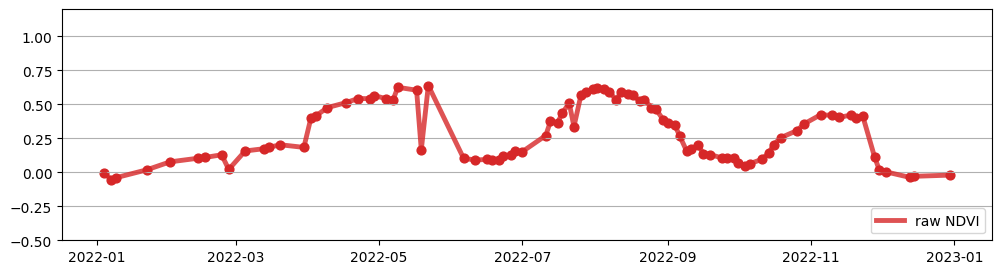

In [ ]:
#  Pick a field
a_field = reduced[reduced.ID==reduced.ID.unique()[0]].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3),
                       sharex='col', sharey='row',
                       # sharex=True, sharey=True,
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(axis='y', which="both")

ax.scatter(a_field['human_system_start_time'], a_field[VI_idx], s=40, c='#d62728');
ax.plot(a_field['human_system_start_time'], a_field[VI_idx],
        linestyle='-',  linewidth=3.5, color="#d62728", alpha=0.8,
        label=f"raw {VI_idx}")
plt.ylim([-0.5, 1.2]);
ax.legend(loc="lower right");
# ax.set_title(a_field.CropTyp.unique()[0]);

**Remove outliers**

In [ ]:
reduced["ID"] = reduced["ID"].astype(str)
# p = np.sort(reduced["ID"].unique())

In [ ]:
no_outlier_df = pd.DataFrame(data = None,
                             index = np.arange(reduced.shape[0]),
                             columns = reduced.columns)
counter = 0
row_pointer = 0
for a_poly in reduced["ID"].unique():
    if (counter % 1000 == 0):
        print ("counter is [{:.0f}].".format(counter))
    curr_field = reduced[reduced["ID"]==a_poly].copy()
    # small fields may have nothing in them!
    if curr_field.shape[0] > 2:
        ##************************************************
        #
        #    Set negative index values to zero.
        #
        ##************************************************
        no_Outlier_TS = nc.interpolate_outliers_EVI_NDVI(outlier_input = curr_field, given_col = VI_idx)
        no_Outlier_TS.loc[no_Outlier_TS[VI_idx
                                        ] < 0 , VI_idx] = 0

        """
        it is possible that for a field we only have x=2 data points
        where all the EVI/NDVI is outlier. Then, there is nothing to
        use for interpolation. So, hopefully interpolate_outliers_EVI_NDVI is returning an empty data table.
        """
        if len(no_Outlier_TS) > 0:
            no_outlier_df[row_pointer: row_pointer + curr_field.shape[0]] = no_Outlier_TS.values
            counter += 1
            row_pointer += curr_field.shape[0]

# Sanity check. Will neved occur. At least should not!
no_outlier_df.drop_duplicates(inplace=True)

counter is [0].


**Remove the jumps**

Maybe we can remove old/previous dataframes to free memory up!

In [ ]:
noJump_df = pd.DataFrame(data = None,
                         index = np.arange(no_outlier_df.shape[0]),
                         columns = no_outlier_df.columns)
counter, row_pointer = 0, 0

for a_poly in no_outlier_df["ID"].unique():
    if (counter % 1000 == 0):
        print ("counter is [{:.0f}].".format(counter))
    curr_field = no_outlier_df[no_outlier_df["ID"]==a_poly].copy()

    ################################################################
    # Sort by DoY (sanitary check)
    curr_field.sort_values(by=['human_system_start_time'], inplace=True)
    curr_field.reset_index(drop=True, inplace=True)

    ################################################################

    no_Outlier_TS = nc.correct_big_jumps_1DaySeries_JFD(dataTMS_jumpie = curr_field,
                                                        give_col = VI_idx
                                                        ,
                                                        maxjump_perDay = 0.018)

    noJump_df[row_pointer: row_pointer + curr_field.shape[0]] = no_Outlier_TS.values
    counter += 1
    row_pointer += curr_field.shape[0]

noJump_df['human_system_start_time'] = pd.to_datetime(noJump_df['human_system_start_time'])

# Sanity check. Will neved occur. At least should not!
print ("Shape of noJump_df before dropping duplicates is {}.".format(noJump_df.shape))
noJump_df.drop_duplicates(inplace=True)
print ("Shape of noJump_df after dropping duplicates is {}.".format(noJump_df.shape))

del(no_Outlier_TS)

counter is [0].
Shape of noJump_df before dropping duplicates is (2314, 5).
Shape of noJump_df after dropping duplicates is (2314, 5).


**Regularize**

Here we regularize the data. "Regularization" means pick a value for every 10-days. Doing this ensures

1.   all inputs have the same length,
2.   by picking maximum value of a VI we are reducing the noise in the time-series by eliminating noisy data points. For example, snow or shaddow can lead to understimating the true VI.

Moreover, here, I am keeping only 3 columns. As long as we have ```ID``` we can
merge the big dataframe with the final result later, here or externally.
This will reduce amount of memory needed. Perhaps I should do this
right the beginning.

In [ ]:
%%time

# define parameters
regular_window_size = 10
reg_cols = ['ID', 'human_system_start_time', VI_idx] # system_start_time list(noJump_df.columns)

st_yr = noJump_df.human_system_start_time.dt.year.min()
end_yr = noJump_df.human_system_start_time.dt.year.max()
no_days = (end_yr - st_yr + 1) * 366 # 14 years, each year 366 days!

no_steps = int(np.ceil(no_days / regular_window_size)) # no_days // regular_window_size

nrows = no_steps * len(IDs)
print('st_yr is {}.'.format(st_yr))
print('end_yr is {}.'.format(end_yr))
print('nrows is {}.'.format(nrows))
print (long_eq)


regular_df = pd.DataFrame(data = None,
                         index = np.arange(nrows),
                         columns = reg_cols)
counter, row_pointer = 0, 0

for a_poly in noJump_df["ID"].unique():
    if (counter % 1000 == 0):
        print ("counter is [{:.0f}].".format(counter))
    curr_field = noJump_df[noJump_df["ID"]==a_poly].copy()
    ################################################################
    # Sort by date (sanitary check)
    curr_field.sort_values(by=['human_system_start_time'], inplace=True)
    curr_field.reset_index(drop=True, inplace=True)

    ################################################################
    regularized_TS = nc.regularize_a_field(a_df = curr_field, \
                                           V_idks = VI_idx, \
                                           interval_size = regular_window_size,\
                                           start_year = st_yr, \
                                           end_year = end_yr)

    regularized_TS = nc.fill_theGap_linearLine(a_regularized_TS = regularized_TS, V_idx = VI_idx)
    # if (counter == 0):
    #     print ("regular_df columns:",     regular_df.columns)
    #     print ("regularized_TS.columns", regularized_TS.columns)

    ################################################################
    # row_pointer = no_steps * counter

    """
       The reason for the following line is that we assume all years are 366 days!
       so, the actual thing might be smaller!
    """
    # why this should not work?: It may leave some empty rows in regular_df
    # but we drop them at the end.
    regular_df[row_pointer : (row_pointer+regularized_TS.shape[0])] = regularized_TS.values
    row_pointer += regularized_TS.shape[0]
    counter += 1

regular_df['human_system_start_time'] = pd.to_datetime(regular_df['human_system_start_time'])
regular_df.drop_duplicates(inplace=True)
regular_df.dropna(inplace=True)

# Sanity Check
regular_df.sort_values(by=["ID", 'human_system_start_time'], inplace=True)
regular_df.reset_index(drop=True, inplace=True)

del(noJump_df)

st_yr is 2022.
end_yr is 2022.
nrows is 962.
counter is [0].
CPU times: user 1.46 s, sys: 24.9 ms, total: 1.49 s
Wall time: 1.49 s


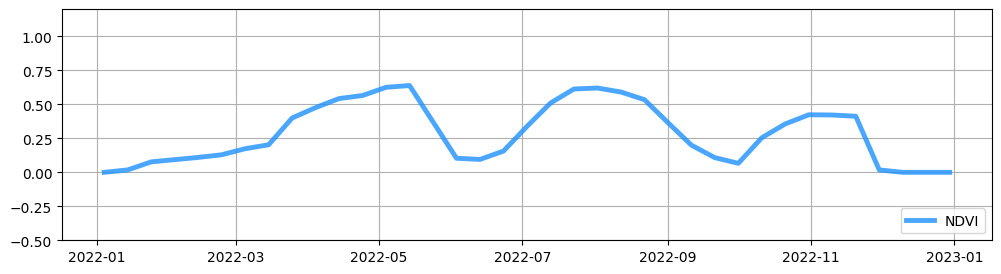

In [ ]:
#  Pick a field
a_field = regular_df[regular_df.ID==reduced.ID.unique()[0]].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex='col', sharey='row',
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'],
        a_field[VI_idx],
        linestyle='-', label=VI_idx, linewidth=3.5, color="dodgerblue", alpha=0.8)

ax.legend(loc="lower right");
plt.ylim([-0.5, 1.2]);

**Savitzky-Golay Smoothing**

In [ ]:
%%time
counter = 0
window_len, polynomial_order = 7, 3

for a_poly in regular_df["ID"].unique():
    if (counter % 300 == 0):
        print ("counter is [{:.0f}].".format(counter))
    curr_field = regular_df[regular_df["ID"]==a_poly].copy()

    # Smoothen by Savitzky-Golay
    SG = scipy.signal.savgol_filter(curr_field[VI_idx].values, window_length=window_len, polyorder=polynomial_order)
    SG[SG > 1 ] = 1 # SG might violate the boundaries. clip them:
    SG[SG < -1 ] = -1
    regular_df.loc[curr_field.index, VI_idx] = SG
    counter += 1

counter is [0].
CPU times: user 68.8 ms, sys: 0 ns, total: 68.8 ms
Wall time: 78.5 ms


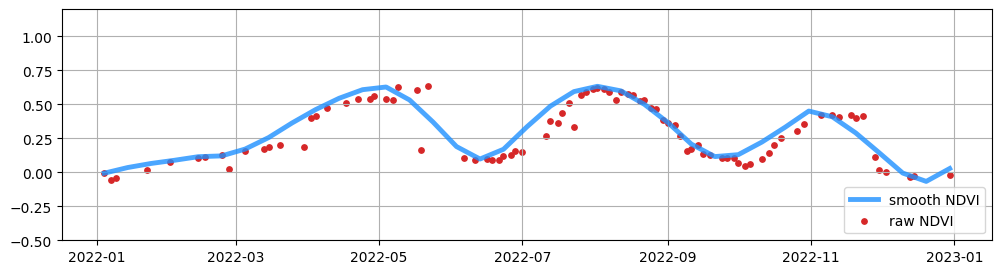

In [ ]:
# Pick a field
an_ID = IDs[0]
a_field = regular_df[regular_df.ID==an_ID].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3), sharex='col', sharey='row', gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field[VI_idx],
        linestyle='-',  linewidth=3.5, color="dodgerblue", alpha=0.8, label=f"smooth {VI_idx}")

# Raw data where we started from
raw = reduced[reduced.ID==an_ID].copy()
raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
ax.scatter(raw['human_system_start_time'], raw[VI_idx], s=15, c='#d62728', label=f"raw {VI_idx}");

ax.legend(loc="lower right");
plt.ylim([-0.5, 1.2]);

In [ ]:
regular_df['human_system_start_time'] = pd.to_datetime(regular_df['human_system_start_time'])
# regular_df = pd.merge(regular_df, SF_data, on=['ID'], how='left') # we can do this later.
regular_df.reset_index(drop=True, inplace=True)
regular_df = nc.initial_clean(df=regular_df, column_to_be_cleaned = VI_idx)
regular_df.head(2)

,ID,human_system_start_time,NDVI
0,field_10_GrantTest2022,2022-01-04,-0.002638
1,field_10_GrantTest2022,2022-01-14,0.000959


**Widen the data to use with ML (other than DL)**

<font size="4.5"><font color='red'>**Note:**</font></font>
At this point we have not released any model other than ```DL``` model.

In [ ]:
model = "DL"

if model != "DL":
    VI_colnames = [VI_idx + "_" + str(ii) for ii in range(1, 37)]
    columnNames = ["ID", "year"] + VI_colnames

    years = regular_df.human_system_start_time.dt.year.unique()
    no_rows = len(IDs) * len(years)

    data_wide = pd.DataFrame(columns=columnNames, index=range(no_rows))
    data_wide.ID = list(IDs) * len(years)
    data_wide.sort_values(by=["ID"], inplace=True)
    data_wide.reset_index(drop=True, inplace=True)
    data_wide.year = list(years) * len(IDs)

    for an_ID in regular_df.ID.unique():
        curr_field = regular_df[regular_df.ID == an_ID]
        curr_years = curr_field.human_system_start_time.dt.year.unique()
        for a_year in curr_years:
            curr_field_year = curr_field[curr_field.human_system_start_time.dt.year == a_year]
            data_wide_indx = data_wide[(data_wide.ID == an_ID) & (data_wide.year == a_year)].index
            if VI_idx == "EVI":
                data_wide.loc[data_wide_indx, "EVI_1":"EVI_36"] = curr_field_year.EVI.values[:36]
            elif VI_idx == "NDVI":
                data_wide.loc[data_wide_indx, "NDVI_1":"NDVI_36"] = curr_field_year.NDVI.values[:36]

### Please tell me where to look for the trained models and I will make you happy!

```model_dir``` is defined on top of the notebook. But, I repeat it here!

In [ ]:
model_dir = data_base + "Models/"

In [ ]:
# import pickle

if model == "KNN":
    winnerModel = "KNN_SG_NDVI_Oct17_AccScoring_Oversample_SR3.sav"
elif model == "SVM":
    winnerModel = "SG_NDVI_SVM_NoneWeight_00_Oct17_AccScoring_Oversample_SR3.sav"
elif model =="RF":
    winnerModel = "SG_NDVI_RF_grid_2_Oct17_AccScoring_Oversample_SR5.sav"
else:
    winnerModel = "01_TL_NDVI_SG_train80_Oct17_oversample5.h5"
    winnerModel = "TL_NDVI_SG.h5"

###
### Load model and predict
###
if winnerModel.endswith(".sav"):
    # ML_model = pickle.load(open(model_dir + winnerModel, "rb"))
    ML_model = pd.read_pickle(model_dir + winnerModel)
    predictions = ML_model.predict(data_wide.iloc[:, 2:])
    pred_colName = model + "_" + VI_idx  + "_preds"
    A = pd.DataFrame(columns=["ID", "year", pred_colName])
    A.ID = data_wide.ID.values
    A.year = data_wide.year.values
    A[pred_colName] = predictions
    predictions = A.copy()
    del A
else:
    from tensorflow.keras.utils import to_categorical, load_img, img_to_array
    from keras.models import Sequential, Model, load_model
    from keras.applications.vgg16 import VGG16
    import tensorflow as tf

    # from keras.optimizers import SGD
    from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
    from tensorflow.keras.optimizers import SGD
    from keras.preprocessing.image import ImageDataGenerator

    #### Form predictions' dataframe
    predictions = pd.DataFrame({"ID": list(regular_df.ID.unique())})
    predictions["prob_single"] = -1.0

    ML_model = load_model(model_dir + winnerModel) # load model

    image_dir = '/content/drive/MyDrive/colab_outputs/'
    image_dir = data_base + "joel_figures/"
    image_name = image_dir + "fly_test.jpg"
    for an_ID in regular_df.ID.unique():
        crr_fld = regular_df[regular_df.ID == an_ID]
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 2.5)
        ax.grid(False)
        ax.plot(
            crr_fld["human_system_start_time"], crr_fld[VI_idx], c="dodgerblue", linewidth=5
        )
        ax.axis("off")
        left = crr_fld["human_system_start_time"].values[0]
        right = crr_fld["human_system_start_time"].values[-1]
        ax.set_xlim([left, right]);
        # the following line also works
        ax.set_ylim([-0.005, 1]);

        plt.savefig(fname = image_name, dpi = 200, bbox_inches = "tight", facecolor = "w")
        plt.close("all")

        img = nc.load_image(image_name)
        predictions.loc[predictions.ID == an_ID, "prob_single"] = ML_model.predict(img, verbose=False)[0][0]

In [ ]:
predictions = pd.merge(predictions, SF_data, on=['ID'], how='left')
predictions.sort_values(by=["ID"], inplace=True)
predictions

,ID,prob_single,Acres,county,CropTyp,DataSrc,Irrigtn,LstSrvD
0,field_10_GrantTest2022,1.000000,81.0,Grant,"Bean, Dry",WSDA,Center Pivot,8/4/2020
1,field_11_GrantTest2022,0.000019,43.0,Grant,Alfalfa Hay,WSDA,Center Pivot,7/14/2020
2,field_12_GrantTest2022,1.000000,9.0,Grant,"Bean, Dry",WSDA,Center Pivot,8/4/2020
3,field_13_GrantTest2022,0.001527,6.0,Grant,Alfalfa Hay,WSDA,Sprinkler,7/14/2020
4,field_14_GrantTest2022,0.000518,110.0,Grant,Alfalfa Hay,WSDA,Center Pivot,7/14/2020
5,field_15_GrantTest2022,0.000392,6.0,Grant,"Corn, Field",WSDA,Sprinkler,7/14/2020
6,field_16_GrantTest2022,0.000330,5.0,Grant,"Corn, Field",WSDA,Center Pivot,7/14/2020
7,field_17_GrantTest2022,1.000000,1.0,Grant,"Corn, Field",WSDA,Center Pivot,7/14/2020
8,field_18_GrantTest2022,1.000000,13.0,Grant,"Corn, Field",WSDA,Center Pivot,7/14/2020
9,field_19_GrantTest2022,1.000000,86.0,Grant,"Corn, Field",WSDA,Unknown,7/14/2020


<font size="5"><font color='red'>**Note:**</font></font>
The cut-off threshold for this model is $p=0.3$. If model changes this needs to be adjusted as well.

In [ ]:
a_cut = 0.3
predictions.loc[predictions.prob_single < a_cut, "label"] = "double-cropped"
predictions.loc[predictions.prob_single >= a_cut, "label"] = "single-cropped"
# predictions["label"] = predictions["label"].astype(int)
predictions.head(2)

,ID,prob_single,Acres,county,CropTyp,DataSrc,Irrigtn,LstSrvD,label
0,field_10_GrantTest2022,1.000000,81.0,Grant,"Bean, Dry",WSDA,Center Pivot,8/4/2020,single-cropped
1,field_11_GrantTest2022,0.000019,43.0,Grant,Alfalfa Hay,WSDA,Center Pivot,7/14/2020,double-cropped


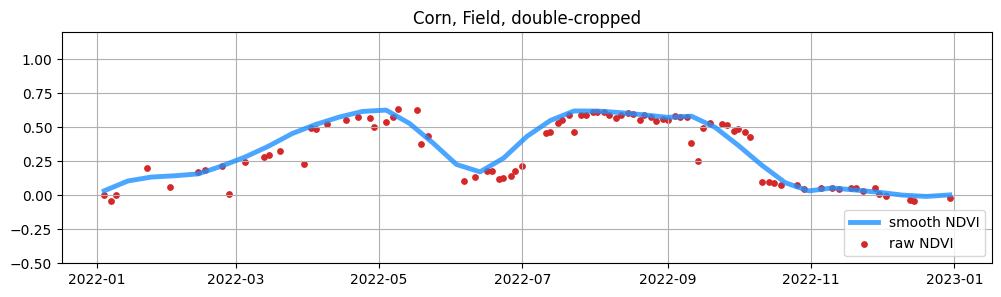

In [ ]:
#  Pick a field
an_ID = IDs[3]
a_field = regular_df[regular_df.ID==an_ID].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3),
                       sharex='col', sharey='row',
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field[VI_idx],
        linestyle='-',  linewidth=3.5, color="dodgerblue", alpha=0.8,
        label=f"smooth {VI_idx}")

# Raw data where we started from
raw = reduced[reduced.ID==an_ID].copy()
raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
ax.scatter(raw['human_system_start_time'], raw[VI_idx], s=15, c='#d62728', label=f"raw {VI_idx}");

crop_ = predictions[predictions.ID == an_ID]["CropTyp"].values[0]
if model=="DL":
  label_ = predictions[predictions.ID==an_ID]["label"].values[0]
else:
  ss = model + "_" + "VI_idx" + "_preds"
  label_ = list(predictions.loc[predictions.ID==an_ID, ss])[0]
  label_ = f"SVM prediction is {label_}."

ax.set_title(crop_ + ", " + label_)
ax.legend(loc="lower right");
plt.ylim([-0.5, 1.2]);

##### Export predictions to Google Drive!

In [ ]:
pred_dir = data_base + "joel_data/predicted_classes/"
out_fileName = "Grant_4Fields" + \
                start_date.replace("-", "_") + \
                end_date.replace("-", "_") + ".csv"

out_name = pred_dir + out_fileName
predictions.to_csv(out_name, index=False)

In [ ]:
import pickle
from datetime import datetime

out_fileName = "Grant_4Fields" + \
                start_date.replace("-", "_") + \
                end_date.replace("-", "_") + ".sav"

out_name = pred_dir + out_fileName

export_ = {"predictions": predictions,
           "source_code" : "joel_pipeline.ipynb",
           "Author": "HN",
           "Date" : datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
           "Present": "Amin, HN, Joel, Kirti",
           "Meeting": "Recorded on Zoom: https://www.youtube.com/watch?v=FuBz4IIqw7Y&ab_channel=HosseinNoorazar"}

pickle.dump(export_, open(out_name, 'wb'))

In [ ]:
predictions

,ID,prob_single,Acres,county,CropTyp,DataSrc,Irrigtn,LstSrvD,label
0,field_10_GrantTest2022,1.000000,81.0,Grant,"Bean, Dry",WSDA,Center Pivot,8/4/2020,single-cropped
1,field_11_GrantTest2022,0.000019,43.0,Grant,Alfalfa Hay,WSDA,Center Pivot,7/14/2020,double-cropped
2,field_12_GrantTest2022,1.000000,9.0,Grant,"Bean, Dry",WSDA,Center Pivot,8/4/2020,single-cropped
3,field_13_GrantTest2022,0.001527,6.0,Grant,Alfalfa Hay,WSDA,Sprinkler,7/14/2020,double-cropped
4,field_14_GrantTest2022,0.000518,110.0,Grant,Alfalfa Hay,WSDA,Center Pivot,7/14/2020,double-cropped
5,field_15_GrantTest2022,0.000392,6.0,Grant,"Corn, Field",WSDA,Sprinkler,7/14/2020,double-cropped
6,field_16_GrantTest2022,0.000330,5.0,Grant,"Corn, Field",WSDA,Center Pivot,7/14/2020,double-cropped
7,field_17_GrantTest2022,1.000000,1.0,Grant,"Corn, Field",WSDA,Center Pivot,7/14/2020,single-cropped
8,field_18_GrantTest2022,1.000000,13.0,Grant,"Corn, Field",WSDA,Center Pivot,7/14/2020,single-cropped
9,field_19_GrantTest2022,1.000000,86.0,Grant,"Corn, Field",WSDA,Unknown,7/14/2020,single-cropped


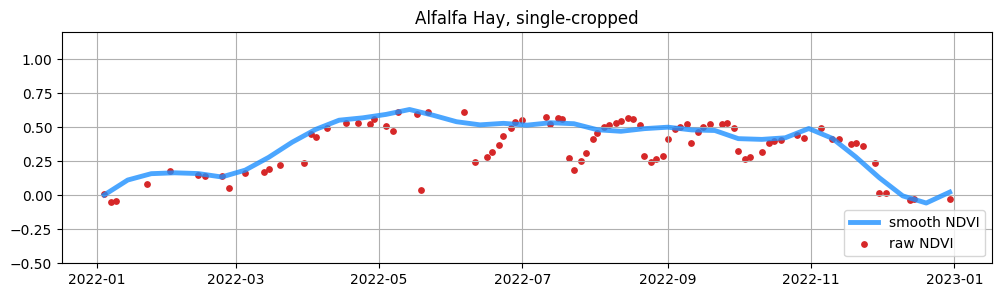

In [ ]:
#  Pick a field
an_ID = "field_9_GrantTest2022"
a_field = regular_df[regular_df.ID==an_ID].copy()
a_field.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 3),
                       sharex='col', sharey='row',
                       gridspec_kw={'hspace': 0.2, 'wspace': .05});
ax.grid(True);
ax.plot(a_field['human_system_start_time'], a_field[VI_idx],
        linestyle='-',  linewidth=3.5, color="dodgerblue", alpha=0.8,
        label=f"smooth {VI_idx}")

# Raw data where we started from
raw = reduced[reduced.ID==an_ID].copy()
raw.sort_values(by='human_system_start_time', axis=0, ascending=True, inplace=True)
ax.scatter(raw['human_system_start_time'], raw[VI_idx], s=15, c='#d62728', label=f"raw {VI_idx}");

crop_ = predictions[predictions.ID == an_ID]["CropTyp"].values[0]
if model=="DL":
  label_ = predictions[predictions.ID==an_ID]["label"].values[0]
else:
  ss = model + "_" + "VI_idx" + "_preds"
  label_ = list(predictions.loc[predictions.ID==an_ID, ss])[0]
  label_ = f"SVM prediction is {label_}."

ax.set_title(crop_ + ", " + label_)
ax.legend(loc="lower right");
plt.ylim([-0.5, 1.2]);